In [1]:
from osgeo import ogr, osr
from shapely import wkt
from shapely.geometry import GeometryCollection
import os

In [2]:
def reproject_layer(inLayer, outSpatialRef, target_ds, target_name):
    inSpatialRef = inLayer.GetSpatialRef()
    coordTrans = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)
    # create the output layer
    if target_ds.GetLayer(target_name):
        target_ds.DeleteLayer(target_name)
    outLayer = target_ds.CreateLayer(
        target_name, 
        outSpatialRef,
        geom_type=inLayer.GetGeomType())
    # add fields
    inLayerDefn = inLayer.GetLayerDefn()
    for i in range(inLayerDefn.GetFieldCount()):
        fieldDefn = inLayerDefn.GetFieldDefn(i)
        outLayer.CreateField(fieldDefn)
    # get the output layer's feature definition
    outLayerDefn = outLayer.GetLayerDefn()
    # loop through the input features
    inFeature = inLayer.GetNextFeature()
    while inFeature:
        # get the input geometry
        geom = inFeature.GetGeometryRef()
        # reproject the geometry
        geom.Transform(coordTrans)
        # create a new feature
        outFeature = ogr.Feature(outLayerDefn)
        # set the geometry and attribute
        outFeature.SetGeometry(geom)
        for i in range(0, outLayerDefn.GetFieldCount()):
            outFeature.SetField(outLayerDefn.GetFieldDefn(i).GetNameRef(), inFeature.GetField(i))
        # add the feature to the shapefile
        outLayer.CreateFeature(outFeature)
        # dereference the features and get the next input feature
        outFeature = None
        inFeature = inLayer.GetNextFeature()

In [3]:
def transform_geometry(a_geom, b_geom):
    coordTrans = osr.CoordinateTransformation(
        a_geom.GetSpatialReference(), b_geom.GetSpatialReference())
    a_geom.Transform(coordTrans)

In [4]:
navajo_ds = ogr.Open('data/navajo')
navajo_lyr = navajo_ds.GetLayer('cb_2017_us_aiannh_500k')

In [5]:
utah_ds = ogr.Open('data/utah', 1)

utah_lyr = utah_ds.GetLayer('Utah')

In [6]:
navajo_feat = navajo_lyr.GetFeature(158)
navajo_feat.NAME

'Navajo Nation'

In [7]:
navajo_geom = navajo_feat.geometry().Clone()

In [8]:
utah_feat = utah_lyr.GetFeature(1)
utah_feat.State

'Utah'

In [9]:
utah_geom = utah_feat.geometry().Clone()

In [10]:
inSpatialRef = navajo_geom.GetSpatialReference()
outSpatialRef = utah_geom.GetSpatialReference()
coordTrans = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)

In [11]:
navajo_geom.Transform(coordTrans)

0

In [12]:
navajo_geom.Intersection(utah_geom).GetArea()

5183358607.807949

In [13]:
e_ds = ogr.Open('data/electric_power_lines')
e_lyr = e_ds.GetLayer('Electric_Power_Transmission_Lines')
reproject_layer(e_lyr, outSpatialRef, utah_ds, 'Electric_Power_Transmission_Lines')

In [14]:
del e_ds
del utah_ds

In [15]:
ds = ogr.Open('data/utah')

utah = ds.GetLayer('Utah')
e_lyr = ds.GetLayer('Electric_Power_Transmission_Lines')

In [16]:
utah_feat = utah.GetFeature(1)

In [17]:
utah_geom = utah_feat.geometry().Clone()
utah_geom

<osgeo.ogr.Geometry; proxy of <Swig Object of type 'OGRGeometryShadow *' at 0x7f0e90fbefc0> >

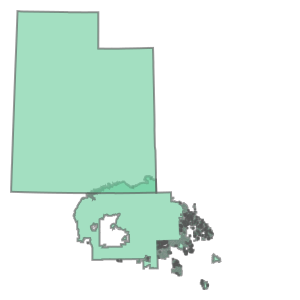

In [18]:
GeometryCollection([wkt.loads(navajo_geom.ExportToWkt()), wkt.loads(utah_geom.ExportToWkt())])

In [19]:
inters = navajo_geom.Intersection(utah_geom)

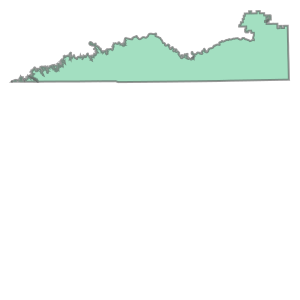

In [20]:
wkt.loads(inters.ExportToWkt())

In [21]:
e_lyr.SetSpatialFilter(inters)

In [22]:
geometries = []
for f in e_lyr:
    geometries.append(f.geometry().Clone())

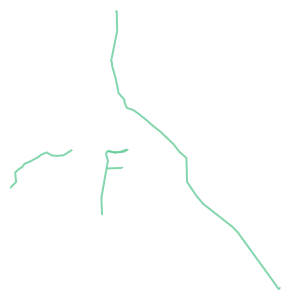

In [23]:
lines = [wkt.loads(g.ExportToWkt()) for g in geometries]
GeometryCollection(lines)

In [24]:
len(geometries)

9

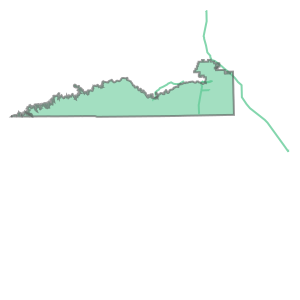

In [25]:
GeometryCollection(lines + [wkt.loads(inters.ExportToWkt())])

In [26]:
del navajo_ds